### Primal Slab SVM
Let $K \in R^{m \times m}$ and $K_{ij} = \texttt{kernel}(x_i,x_j)$ and $K_{i}$ the $i^{th}$ column of $K$

Then Primal Minimization Objective:
$$\min_{\beta \in R^m} \beta^T K \beta + \frac{1}{\nu m} \sum_i \texttt{loss}(K_i^T \beta)$$

Let $F$ be the objective function.
$$F(\beta) = \beta^T K \beta + \frac{1}{\nu m} \sum_i \texttt{loss}(K_i^T \beta)$$

Gradient:
$$\vec\nabla F(\beta) = 2K\beta + \frac {1}{\nu m} \sum_i K_i \frac{d}{d\beta}\texttt{loss}(K_i^T \beta)$$

We consider losses:
$$\texttt{loss}_{hinge}(t) = \max(~0,~ |~\rho - t~| - \delta ~)$$
$$\texttt{loss}_{square-hinge}(t) = \max(~0,~ |~\rho - t~| - \delta ~)^2$$


Loss Gradients:
$$\frac{d}{dt}\texttt{loss}_{hinge}(t) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
-1, & \mbox{if } ~\rho - t~ \gt \delta  \\
1, & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$

$$\frac{d}{dt}\texttt{loss}_{square-hinge}(t) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
-2\left(\rho-t-\delta\right), & \mbox{if } ~\rho - t~ \gt \delta  \\
2\left(-\rho+t-\delta\right), & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$


Evaluation:
$$ \langle \Phi(x), w\rangle = \sum_k \beta_k k(x_k, x) $$

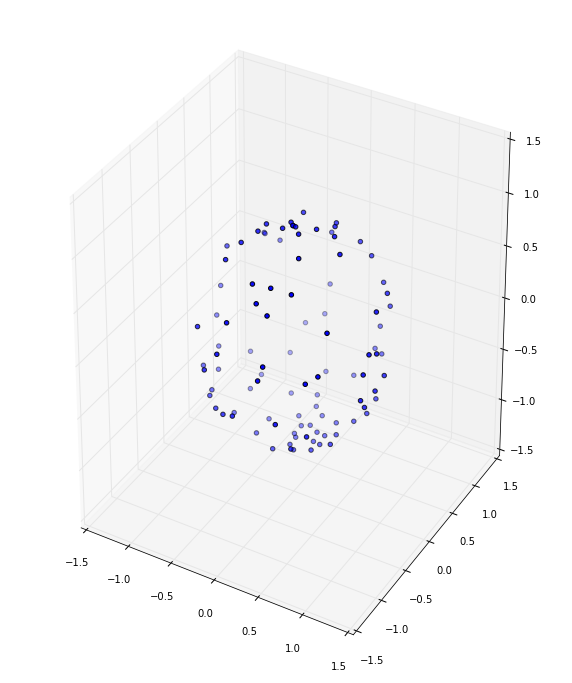

Descent Complete
grad_des: 7.64193105698
(0,)
(0,)
(0,)
(0,)
(0,)
(125000,)
(0,)
(0,)
(125000,)
0.899331377854
0.899904531759
[[[ 0.89937412  0.8993878   0.89940087 ...,  0.89936897  0.89935448
    0.89933939]
  [ 0.89938834  0.89940202  0.89941509 ...,  0.89938319  0.8993687
    0.89935361]
  [ 0.89940196  0.89941564  0.89942871 ...,  0.89939682  0.89938232
    0.89936723]
  ..., 
  [ 0.89939461  0.89940828  0.89942136 ...,  0.89938946  0.89937496
    0.89935987]
  [ 0.89938066  0.89939433  0.89940741 ...,  0.89937551  0.89936102
    0.89934592]
  [ 0.89936611  0.89937979  0.89939286 ...,  0.89936096  0.89934647
    0.89933138]]

 [[ 0.89938897  0.89940265  0.89941572 ...,  0.89938383  0.89936933
    0.89935424]
  [ 0.89940319  0.89941687  0.89942994 ...,  0.89939805  0.89938355
    0.89936846]
  [ 0.89941681  0.89943049  0.89944357 ...,  0.89941167  0.89939717
    0.89938208]
  ..., 
  [ 0.89940946  0.89942313  0.89943621 ...,  0.89940431  0.89938982
    0.89937472]
  [ 0.89939551  0

In [15]:
%matplotlib inline

import numpy as np
from numpy import linalg, random, ones, zeros
from numpy.linalg import norm
from sklearn.cross_validation import train_test_split
import mosek
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
import time 

v=.99
delta = 0.1
sigma = 100
rho = 1
max_iter = 100
grid_steps = 50
initial_step_size = .1
timer_thresh = .1
loss_type = 'hinge'
loss_type = 'square-hinge'
x=np.zeros((0))
K=np.zeros((0))

def loss_der(t):
    if loss_type == 'hinge':
        if abs(rho - t) < delta:
            return 0
        if rho - t > delta:
            return -1
        if -rho + t > delta:
            return 1
    if loss_type == 'square-hinge':
        if abs(rho - t) < delta:
            return 0
        if rho - t > delta:
            return -2*(rho - t - delta)
        if -rho + t > delta:
            return 2*(-rho + t - delta)
    raise Exception(loss_type,t,rho,delta)
        
def obj_grad(beta):
    start = time.time()
#     print 'obj_grad'
    ret = 2*np.dot(K,beta)
    for i in range(len(ret)):
        ret += K[:,i]*loss_der(np.dot(K[:,i],beta))
    end = time.time()
    if end - start > timer_thresh:
        print 'obj_grad:',end - start
    return ret

def kernel(x1,x2):
    return math.exp(-1*math.pow(norm(x1-x2),2
                               )/(2*math.pow(sigma, 2)))

def loss(t):
    if loss_type == 'hinge':
        return max(0, abs(rho - t) - delta )
    if loss_type == 'square-hinge':
        return max(0, abs(rho - t) - delta )**2

def obj_funct(beta):
    start = time.time()
#     print 'obj_funct'
    m = len(x)
    loss_sum = 0
    for i in range(len(x)):
        loss_sum += loss(np.dot(K[:,i],beta))
    obj = 1/2*np.dot(beta.T,np.dot(K,beta)) + 1 / (v*m) * loss_sum
    end = time.time()
    if end - start > timer_thresh:
        print 'obj_funct:',end - start
    return obj

def f(x_test, beta):
    start = time.time()
#     print 'f'
    w=0
    for i in range(len(x)):
        w += beta[i]*kernel(x[i],x_test)
    end = time.time()
    if end - start > timer_thresh:
        print 'f:',end - start
    return w

def step(beta,step_size,grad):
    return beta - (step_size * grad)

def backtrack_step_size(step_size,obj,grad,beta):
    start = time.time()
#     print 'backtrack_step_size'
    if step_size == .00000001:
        step_size = initial_step_size
    else:
        step_size *= 2.0
    while obj < obj_funct( step(beta,step_size,grad) ):
#         print 'step_size/2.0',step_size/2.0
        step_size = step_size * 0.8 #/2.0
        if step_size < .00000001:
            step_size = .00000001
            end = time.time()
            if end - start > timer_thresh:
                print 'backtrack_step_size:',end - start
            return step_size

    assert obj >= obj_funct( step(beta,step_size,grad) )
    end = time.time()
    if end - start > timer_thresh:
        print 'backtrack_step_size:',end - start
    return step_size

def numer_grad(beta,ep,delta): # const
    return (obj_funct(beta+(ep*delta)) \
           -obj_funct(beta-(ep*delta)))/(2*ep)


def grad_checker(beta): # const
    ep=.0001
    d=len(beta)
    w=np.zeros(d)
    for i in range(d):
        delta=np.zeros(beta.shape)
        delta[i] = 1
        w[i]=(numer_grad(beta,ep,delta))
    return w

def grad_des(x):
    start = time.time()
#     print 'grad_des'
    x = x
    obj_array = -1*np.ones(max_iter)
    obj_grad_array = np.zeros((max_iter,len(x)))
    obj_grad_check_array = np.zeros(max_iter)

    beta = zeros(len(x))
    step_size = initial_step_size
    for i in range(max_iter):
#         print 'iter',i
        obj = obj_funct(beta)
        obj_array[i]=(obj)
#         print 'obj',obj
        grad = obj_grad(beta)
        obj_grad_array[i]=(grad)
        obj_grad_check_array[i]=norm((grad-grad_checker(beta)))

        if norm(grad) < .0000001:
            break
            
        step_size = backtrack_step_size(step_size,obj,grad,beta)
#         print 'step_size',step_size
        
        beta = step(beta,step_size,grad)

#         if len(obj_array)>1 and abs(obj_array[-2] - obj_array[-1])<.001:
#             print 'obj diff',abs(obj_array[-2] - obj_array[-1])
#             break
        if i == max_iter-1:
            print 'WARNING: Did not converge'

    print 'Descent Complete'
    end = time.time()
    if end - start > timer_thresh:
        print 'grad_des:',end - start
    return obj_array,obj_grad_array,obj_grad_check_array,beta

def get_data_points():
    start = time.time()
    r=1
    points = random.random((100,2))*2*np.pi

    x = np.zeros((len(points),3))
    for p in range(len(points)):
        z_cord = r * np.sin(points[p][1])

        r_temp = r * np.cos(points[p][1])
        y_cord = r_temp * np.sin(points[p][0])
        x_cord = r_temp * np.cos(points[p][0])

        x[p] = np.asarray([x_cord, y_cord, z_cord])

    for i in range(x.shape[0]):
        x_cord = x[i][0]
        y_cord = x[i][1]
        z_cord = x[i][2]

        if abs(x_cord**2 + y_cord**2 + z_cord**2 - r**2)>0.01:
            assert False
            
    end = time.time()
    if end - start > timer_thresh:
        print 'get_data_points:',end - start
    return x

def pre_comp_K():
    start = time.time()
    K=np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            K[i,j] = kernel(x[i],x[j])
    end = time.time()
    if end - start > timer_thresh:
        print 'pre_comp_K:',end - start
    return K

def proc_results(obj_array,obj_grad_array,beta):
    start = time.time()
    x0_range = np.linspace(-2, 2, grid_steps)
    x1_range = np.linspace(-2, 2, grid_steps)
    x2_range = np.linspace(-2, 2, grid_steps)

    data = np.zeros((grid_steps,grid_steps,grid_steps))

    for i in range(grid_steps):
        for j in range(grid_steps):
            for k in range(grid_steps):
                x_temp = np.asarray([x0_range[i],
                                    x1_range[j],
                                    x2_range[k]])
                data[i,j,k] = f(x_temp, beta)

    print (np.where(np.abs(data - delta) < .1)[0].shape)
    print (np.where(np.abs(data - delta) < .01)[0].shape)
    print (np.where(np.abs(data - delta) < .001)[0].shape)
    print (np.where(np.abs(data - delta) < .0001)[0].shape)
    print (np.where(data < delta )[0].shape)
    print (np.where(data > delta )[0].shape)
    print (np.where( data < 0)[0].shape)
    print (np.where( data == 0)[0].shape)
    print (np.where( data > 0)[0].shape)
    print (np.amin( data ))
    print (np.amax( data ))
    print data
    
    end = time.time()
    if end - start > timer_thresh:
        print 'proc_results:',end - start

x = get_data_points()        
        
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2])
plt.show()

K = pre_comp_K()    
    
obj_array,obj_grad_array,obj_grad_check_array,beta = grad_des(x)

proc_results(obj_array,obj_grad_array,beta)


<IPython.core.display.Javascript object>


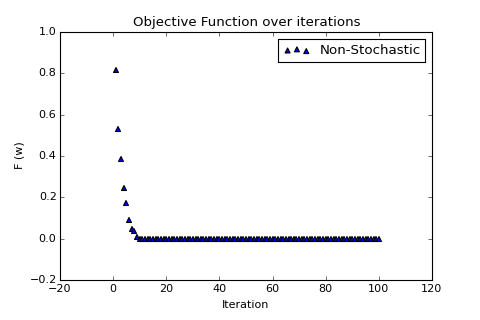

In [17]:
%matplotlib nbagg
plt.clf()
plt.cla()

ax = plt.subplot(1,1,1)

ax.scatter(range(1,len(obj_array)+1),obj_array,marker='^',label='Non-Stochastic')

# obj_stoch_array = np.asarray(obj_stoch_array)
# ax.scatter(range(1,len(obj_stoch_array)+1),obj_stoch_array,marker='*',label='Stochastic')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Objective Function over iterations')
plt.ylabel('F (w)')
plt.xlabel('Iteration')

<IPython.core.display.Javascript object>


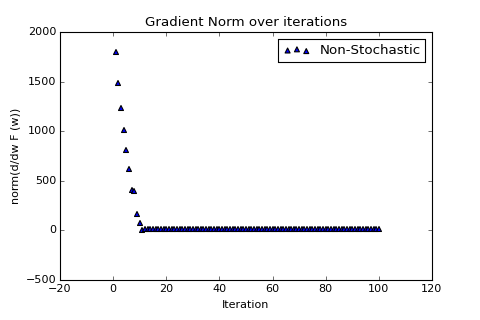

In [18]:
%matplotlib nbagg
plt.clf()
plt.cla()

from numpy.linalg import norm

ax = plt.subplot(1,1,1)

obj_grad_norm_array = np.zeros(len(obj_grad_array))
for i in range(len(obj_grad_array)):
    obj_grad_norm_array[i] = norm(obj_grad_array[i])
    
ax.scatter(range(1,len(obj_grad_norm_array)+1),obj_grad_norm_array,marker='^',label='Non-Stochastic')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Gradient Norm over iterations')
plt.ylabel('norm(d/dw F (w))')
plt.xlabel('Iteration')

<IPython.core.display.Javascript object>


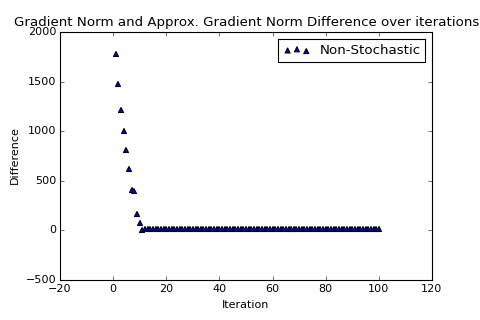

In [19]:
%matplotlib nbagg
plt.clf()
plt.cla()

from numpy.linalg import norm

ax = plt.subplot(1,1,1)

ax.scatter(range(1,len(obj_grad_check_array)+1),obj_grad_check_array,marker='^',label='Non-Stochastic')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Gradient Norm and Approx. Gradient Norm Difference over iterations')
plt.ylabel('Difference')
plt.xlabel('Iteration')